In [226]:
from tba_pydata import api, analysis
from tba_pydata.games import power_up_2018 as powerup
from numpy import arctanh, tanh
from scipy.stats import t

import pandas
import statsmodels.api as sm

In [227]:
event = '2018vagle'
matches = api.matches(event=event, score_parsing_fn=powerup.scoring)
#finishes = api.event_finish(event)
#matches = pandas.read_pickle('2018wk1.pickle')
matches.columns

https://www.thebluealliance.com/api/v3/event/2018vagle/matches 200


Index(['actual_time', 'alliances', 'comp_level', 'event_key', 'key',
       'match_number', 'post_result_time', 'predicted_time', 'score_breakdown',
       'set_number',
       ...
       'blue_ownership_switch_force', 'blue_ownership_points',
       'blue_endgame_robot1', 'blue_endgame_robot2', 'blue_endgame_robot3',
       'blue_endgame_true_climb', 'blue_endgame_climb', 'blue_endgame_park',
       'blue_endgame_rp', 'blue_endgame_points'],
      dtype='object', length=103)

In [228]:
matches['red_ownership_norm'] = 2*arctanh(((matches.red_ownership_scale_sec + matches.red_ownership_switch_sec + 2) / 139) - 1)
matches['blue_ownership_norm'] = 2*arctanh(((matches.blue_ownership_scale_sec + matches.blue_ownership_switch_sec + 2) / 139) - 1)

In [229]:
matches['red_misc'] = matches.red_endgame_points + matches.red_vault_points \
+ matches.red_ownership_scale_boost + matches.red_ownership_scale_force
matches['blue_misc'] = matches.blue_endgame_points + matches.blue_vault_points \
+ matches.blue_ownership_scale_boost + matches.blue_ownership_scale_force

In [230]:
def get_psr_matrices(df, score_col='score', teams=None):
    red_score = 'red_' + score_col
    blue_score = 'blue_' + score_col
    df = df[['key', red_score, blue_score, 'red1', 'red2', 'red3', 'blue1', 'blue2', 'blue3']]
    melted = pandas.melt(df, ['key', red_score, blue_score]).sort_values('value')
    teams = melted.value.unique() if teams is None else teams
    scores = pandas.melt(df[['key', red_score, blue_score]], ['key']).sort_values('key')
    scores.index = scores.key + '_' + scores.variable
    oprmat = pandas.DataFrame(0, index=scores.key + '_' + scores.variable, columns=teams)

    for (i, record) in melted.iterrows():
        if record.variable.startswith('blue'): 
            oprmat.loc[record.key + '_' + blue_score, record.value] = 1
            oprmat.loc[record.key + '_' + red_score, record.value] = -1
        if record.variable.startswith('red'): 
            oprmat.loc[record.key + '_' + blue_score, record.value] = -1
            oprmat.loc[record.key + '_' + red_score, record.value] = 1

    return oprmat, teams, scores

In [231]:
def get_psr_model(df, fit=True, score_col='score', teams=None):
    df = df[df.comp_level == 'qm']
    oprmat, teams, scores = get_psr_matrices(df, score_col=score_col, teams=teams)
    reg = sm.OLS(scores.value, oprmat)

    if fit:
        return reg.fit()
    else:
        return reg

In [232]:
m = get_psr_model(matches, score_col='ownership_norm')
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     3.131
Date:                Sat, 10 Mar 2018   Prob (F-statistic):           1.87e-05
Time:                        22:44:10   Log-Likelihood:                -160.80
No. Observations:                 110   AIC:                             389.6
Df Residuals:                      76   BIC:                             481.4
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
frc1086       -0.1841      0.335     -0.550      0.584      -0.851       0.483
frc1262        1.1584      0.378      3.064      0.003       0.405       1.912
frc1413       -0.3197      0.372     -0.859      0.393      -1.061       0.422
frc1522        0.5870      0.372      1.576      0.119      -0.155       1.329
frc1598       -1.1898      0.344     -3.463      0.001      -1.874      -0.505
frc1599        0.2542      0.328      0.776      0.440      -0.398       0.907
frc1610        0.0291      0.326      0.089      0.929      -0.620       0.678
frc1793       -0.8663      0.339     -2.557      0.013      -1.541      -0.192
frc1908       -0.2650      0.353     -0.751      0.455      -0.968       0.438
frc2028        0.2112      0.391      0.540      0.591      -0.568       0.991
frc2068        0.0761      0.323      0.235      0.814      -0.567       0.719
frc2106        0.2373      0.331      0.716      0.476      -0.423       0.897
frc2998       -0.1113      0.332     -0.336      0.738      -0.772       0.549
frc3136       -0.0835      0.353     -0.237      0.814      -0.786       0.619
frc3258        0.5524      0.368      1.502      0.137      -0.180       1.285
frc3361       -0.3546      0.336     -1.056      0.294      -1.023       0.314
frc339        -0.1225      0.370     -0.331      0.741      -0.859       0.614
frc346         0.0944      0.418      0.226      0.822      -0.738       0.927
frc384         0.4248      0.313      1.359      0.178      -0.198       1.048
frc3939        0.5686      0.358      1.589      0.116      -0.144       1.281
frc401        -0.6803      0.351     -1.939      0.056      -1.379       0.018
frc4286       -0.6283      0.362     -1.735      0.087      -1.350       0.093
frc4795        0.7157      0.384      1.862      0.066      -0.050       1.481
frc5279        0.0111      0.334      0.033      0.974      -0.654       0.677
frc540        -0.1741      0.338     -0.516      0.608      -0.847       0.499
frc5804       -0.1339      0.325     -0.412      0.681      -0.780       0.513
frc5950       -0.1709      0.360     -0.474      0.637      -0.888       0.547
frc5954       -0.4771      0.316     -1.511      0.135      -1.106       0.152
frc5957       -0.1765      0.364     -0.484      0.630      -0.902       0.549
frc6021       -0.2469      0.357     -0.692      0.491      -0.957       0.464
frc617        -0.7130      0.326     -2.189      0.032      -1.362      -0.064
frc6189        0.0828      0.317      0.261      0.795      -0.549       0.715
frc6802        1.0510      0.380      2.767      0.007       0.295       1.807
frc6882        0.6843      0.404      1.694      0.094      -0.120       1.489
frc836         0.1595      0.340      0.469      0.640      -0.518       0.837
==============================================================================
Om

In [233]:
p = analysis.get_opr_model(matches, score_col='misc')
p.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     2.492
Date:                Sat, 10 Mar 2018   Prob (F-statistic):           0.000524
Time:                        22:44:10   Log-Likelihood:                -505.46
No. Observations:                 110   AIC:                             1081.
Df Residuals:                      75   BIC:                             1175.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
frc1086       27.0995      9.949      2.724      0.008       7.279      46.920
frc1262       54.9714     10.625      5.174      0.000      33.806      76.137
frc1413       46.6242     10.520      4.432      0.000      25.668      67.580
frc1522        7.4568     10.444      0.714      0.477     -13.348      28.261
frc1598        7.7304      9.930      0.779      0.439     -12.050      27.511
frc1599       18.7097      9.958      1.879      0.064      -1.127      38.547
frc1610       21.2836      9.914      2.147      0.035       1.535      41.033
frc1793       19.0806      9.871      1.933      0.057      -0.584      38.746
frc1908        0.6074     10.623      0.057      0.955     -20.554      21.769
frc2028        2.5943     10.523      0.247      0.806     -18.368      23.557
frc2068        3.5016     10.005      0.350      0.727     -16.430      23.433
frc2106        8.3012      9.944      0.835      0.406     -11.509      28.111
frc2998        3.3704     10.585      0.318      0.751     -17.717      24.458
frc3136       14.1169      9.980      1.415      0.161      -5.763      33.997
frc3258       20.1369     10.636      1.893      0.062      -1.051      41.324
frc3361       -1.7059     10.558     -0.162      0.872     -22.738      19.326
frc339        31.8876     10.023      3.181      0.002      11.921      51.854
frc346        40.9199     10.605      3.859      0.000      19.794      62.046
frc384        41.5540      9.908      4.194      0.000      21.817      61.291
frc3939       15.0409     10.541      1.427      0.158      -5.957      36.039
frc401        26.0840     10.512      2.481      0.015       5.142      47.026
frc4286       -5.7129     10.548     -0.542      0.590     -26.725      15.299
frc4795       32.9910     10.534      3.132      0.002      12.007      53.975
frc5279       24.2262      9.849      2.460      0.016       4.606      43.847
frc540        15.5927     10.560      1.477      0.144      -5.444      36.630
frc5804       26.5082     10.509      2.522      0.014       5.573      47.443
frc5950       32.8352     10.567      3.107      0.003      11.784      53.886
frc5954       11.5647      9.990      1.158      0.251      -8.336      31.466
frc5957        8.3005     10.034      0.827      0.411     -11.688      28.289
frc6021       -1.7368     10.562     -0.164      0.870     -22.777      19.304
frc617         5.2460     10.621      0.494      0.623     -15.912      26.404
frc6189       14.1888     10.009      1.418      0.160      -5.751      34.128
frc6802       29.5153     10.693      2.760      0.007       8.215      50.816
frc6882       31.0810     10.591      2.935      0.004       9.982      52.180
frc836        24.1768      9.912      2.439      0.017       4.430      43.923
==============================================================================
Om

In [234]:
m.params.sort_values()

frc1598   -1.189847
frc1793   -0.866344
frc617    -0.712956
frc401    -0.680310
frc4286   -0.628306
frc5954   -0.477103
frc3361   -0.354589
frc1413   -0.319730
frc1908   -0.264962
frc6021   -0.246901
frc1086   -0.184147
frc5957   -0.176467
frc540    -0.174118
frc5950   -0.170895
frc5804   -0.133889
frc339    -0.122491
frc2998   -0.111321
frc3136   -0.083473
frc5279    0.011136
frc1610    0.029051
frc2068    0.076056
frc6189    0.082788
frc346     0.094365
frc836     0.159518
frc2028    0.211203
frc2106    0.237250
frc1599    0.254181
frc384     0.424815
frc3258    0.552381
frc3939    0.568620
frc1522    0.587016
frc6882    0.684326
frc4795    0.715747
frc6802    1.050955
frc1262    1.158442
dtype: float64

In [235]:
p.params.sort_values()

frc4286    -5.712930
frc6021    -1.736816
frc3361    -1.705870
frc1908     0.607351
frc2028     2.594292
frc2998     3.370447
frc2068     3.501609
frc617      5.246025
frc1522     7.456799
frc1598     7.730393
frc5957     8.300509
frc2106     8.301236
frc5954    11.564694
frc3136    14.116927
frc6189    14.188753
frc3939    15.040872
frc540     15.592684
frc1599    18.709676
frc1793    19.080578
frc3258    20.136897
frc1610    21.283629
frc836     24.176752
frc5279    24.226186
frc401     26.084011
frc5804    26.508198
frc1086    27.099541
frc6802    29.515304
frc6882    31.080985
frc339     31.887554
frc5950    32.835240
frc4795    32.990997
frc346     40.919874
frc384     41.554006
frc1413    46.624218
frc1262    54.971376
dtype: float64

In [236]:
(((tanh(m.params / 2) + 1) * 137 / 3) + p.params).sort_values()

frc4286     26.061467
frc1598     29.037204
frc617      35.289760
frc3361     35.948128
frc6021     38.320753
frc1908     40.259207
frc1793     46.116663
frc2998     46.497902
frc5954     46.539552
frc5957     49.948270
frc2068     50.904058
frc2028     53.065574
frc401      56.789566
frc540      57.293671
frc3136     57.878728
frc2106     59.359844
frc6189     61.744668
frc1522     66.154930
frc1610     67.613570
frc1086     68.573348
frc5804     69.122286
frc5279     70.147128
frc1599     70.149086
frc3939     73.352144
frc836      73.478033
frc5950     74.609283
frc339      74.760833
frc3258     78.105051
frc1413     85.051940
frc346      88.739607
frc6882     91.790570
frc4795     94.336842
frc384      96.777321
frc6802     97.189497
frc1262    124.480565
dtype: float64

In [237]:
finishmap = {'won':'*', 'f':'s', 'sf':'o', 'qf':'^', 'np': 'x'}
pickmap = {0:'r', 1:'g', 2:'b', -1:(0,0,0)}
seedmap = {8: 20, 7: 20, 6:30, 5:30, 4:40, 3:60, 2:80, 1:140, -1:5}

finish = finishes.finish.apply(lambda v: finishmap[v])
pick = finishes.pick.apply(lambda v: pickmap[v])
seed = finishes.seed.apply(lambda v: seedmap[v])

In [238]:
%matplotlib inline
import matplotlib.pyplot as plt
from numpy import array

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

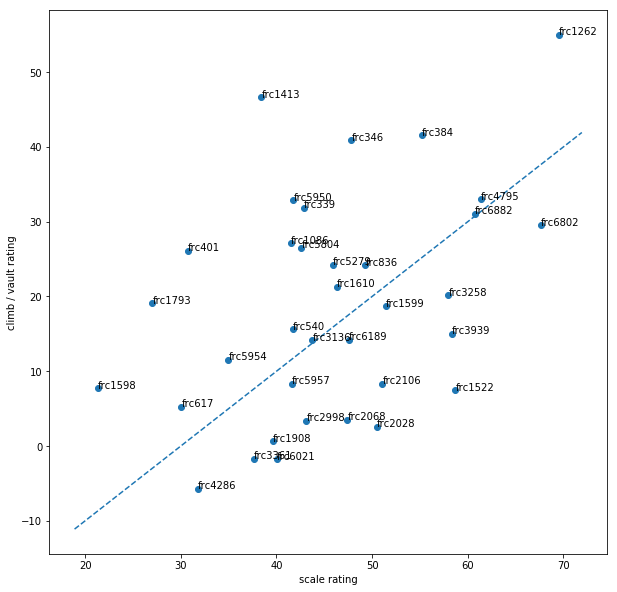

In [239]:
#for finish, marker in finishmap.items():
#    indexer = finishes.finish == finish
#    ax.scatter(md[indexer], p.params[indexer], c=pick[indexer], s=seed[indexer], marker=marker, label=finish)
    
#ax.legend(loc=2)
md = (tanh(m.params / 2) + 1) * 137 / 3

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(md, p.params)
abline(1,-30)
    
plt.xlabel('scale rating')
plt.ylabel('climb / vault rating')
for i, v in p.params.iteritems():
    ax.annotate(i, (md[i], p.params[i]))

In [240]:
def psr_make_prediction(red, blue, model):
    table = [dict.fromkeys(model.params.index, 0) for i in range(2)]
    for r, b in zip(red, blue):
        table[0][r] = 1
        table[0][b] = -1
        table[1][r] = -1
        table[1][b] = 1
    x = pandas.DataFrame.from_dict(table)
    return model.get_prediction(x)

In [241]:
def psr_make_predictions(df, model):
    mat, _, _ = get_psr_matrices(df, teams=model.params.index)
    #x = pandas.DataFrame.from_dict(table)
    return model.get_prediction(mat)

In [242]:
all_matches = api.matches(event=event)
all_matches = all_matches[all_matches.red_score == -1]
all_matches

https://www.thebluealliance.com/api/v3/event/2018vagle/matches 200


,actual_time,alliances,comp_level,event_key,key,match_number,post_result_time,predicted_time,score_breakdown,set_number,...,videos,winning_alliance,blue1,blue2,blue3,red1,red2,red3,red_score,blue_score
key,,,,,,,,,,,,,,,,,,,,,
2018vagle_qm56,NaN,"{'blue': {'dq_team_keys': [], 'score': -1, 'su...",qm,2018vagle,2018vagle_qm56,56,NaN,1520775000,None,1,...,[],,frc1908,frc401,frc6882,frc1262,frc2998,frc3939,-1.0,-1.0
2018vagle_qm57,NaN,"{'blue': {'dq_team_keys': [], 'score': -1, 'su...",qm,2018vagle,2018vagle_qm57,57,NaN,1520775420,None,1,...,[],,frc2028,frc617,frc4286,frc1522,frc346,frc5804,-1.0,-1.0
2018vagle_qm58,NaN,"{'blue': {'dq_team_keys': [], 'score': -1, 'su...",qm,2018vagle,2018vagle_qm58,58,NaN,1520775840,None,1,...,[],,frc1413,frc540,frc6021,frc4795,frc6802,frc5950,-1.0,-1.0
2018vagle_qm59,NaN,"{'blue': {'dq_team_keys': [], 'score': -1, 'su...",qm,2018vagle,2018vagle_qm59,59,NaN,1520776260,None,1,...,[],,frc3258,frc617,frc3939,frc1599,frc1793,frc3361,-1.0,-1.0
2018vagle_qm60,NaN,"{'blue': {'dq_team_keys': [], 'score': -1, 'su...",qm,2018vagle,2018vagle_qm60,60,NaN,1520776680,None,1,...,[],,frc2028,frc540,frc339,frc5279,frc1908,frc1262,-1.0,-1.0
2018vagle_qm61,NaN,"{'blue': {'dq_team_keys': [], 'score': -1, 'su...",qm,2018vagle,2018vagle_qm61,61,NaN,1520777100,None,1,...,[],,frc1086,frc2068,frc346,frc5804,frc401,frc836,-1.0,-1.0
2018vagle_qm62,NaN,"{'blue': {'dq_team_keys': [], 'score': -1, 'su...",qm,2018vagle,2018vagle_qm62,62,NaN,1520777520,None,1,...,[],,frc6802,frc5957,frc6189,frc2998,frc384,frc3136,-1.0,-1.0
2018vagle_qm63,NaN,"{'blue': {'dq_team_keys': [], 'score': -1, 'su...",qm,2018vagle,2018vagle_qm63,63,NaN,1520777940,None,1,...,[],,frc5950,frc6882,frc1522,frc5954,frc1610,frc1413,-1.0,-1.0
2018vagle_qm64,NaN,"{'blue': {'dq_team_keys': [], 'score': -1, 'su...",qm,2018vagle,2018vagle_qm64,64,NaN,1520778360,None,1,...,[],,frc4286,frc3361,frc4795,frc1598,frc3258,frc6021,-1.0,-1.0


In [243]:
import re
pred = psr_make_predictions(all_matches, m).summary_frame()
pred['t'] = pred['mean'] / pred.mean_se
pred['prob'] = t.cdf(pred.t, df=9) * 100
pred['color'] = [re.search(event + '_' + 'qm[0-9]+_(red|blue)_score', m).group(1) for m in pred.index]
pred.index = [re.search('(' + event + '_' + 'qm[0-9]+)_(red|blue)_score', m).group(1) for m in pred.index]
pred = pred[pred.color=='red']
pred

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,t,prob,color
2018vagle_qm56,1.876686,0.938242,0.008016,3.745356,-1.245421,4.998793,2.000216,96.173691,red
2018vagle_qm57,1.677551,0.927297,-0.169322,3.524423,-1.431559,4.786661,1.809075,94.805653,red
2018vagle_qm58,2.336557,1.140077,0.065897,4.607217,-1.041538,5.714652,2.049473,96.466299,red
2018vagle_qm59,-1.374797,0.936049,-3.239100,0.489505,-4.494292,1.744698,-1.468724,8.798583,red
2018vagle_qm60,0.990023,1.122855,-1.246336,3.226382,-2.365111,4.345157,0.881702,79.956387,red
2018vagle_qm61,-0.640955,1.117583,-2.866814,1.584904,-3.989100,2.707190,-0.573519,29.016990,red
2018vagle_qm62,-0.727256,1.000790,-2.720503,1.265991,-3.925483,2.470971,-0.726682,24.294540,red
2018vagle_qm63,-1.868231,1.113739,-4.086434,0.349973,-5.211291,1.474830,-1.677440,6.388444,red
2018vagle_qm64,-0.617220,0.923417,-2.456365,1.221925,-3.721745,2.487306,-0.668408,26.032278,red
2018vagle_qm65,-1.301065,0.985977,-3.264809,0.662678,-4.480989,1.878858,-1.319570,10.977922,red


In [244]:
team='frc1731'
fr = all_matches[ (all_matches.red1==team) | (all_matches.red2==team) | (all_matches.red3==team) ].copy()
frp = fr.join(pred)
fr['prob'] = frp.prob
fr['color'] = 'red'
br = all_matches[ (all_matches.blue1==team) | (all_matches.blue2==team) | (all_matches.blue3==team) ].copy()
brp = br.join(pred)
br['prob'] = 100 - brp.prob
br['color'] = 'blue'

fr.append(br).loc[:,'blue1':]

,blue1,blue2,blue3,red1,red2,red3,red_score,blue_score,prob,color
key,,,,,,,,,,
